## Autoencoder: an algorithm to learn a representation of the dataset 

In this piece I'm interested in a neural network that is not designed to predict an outcome given a dataset, but rather in an algorithm that is capable of learning an underlying - more compressed - representation of the dataset at hand. This can be used for a number of excitng applications such as data compression, latent representation or recovering the true data distribution.
An `autoencoder`, which is a special encoder/decoder network, is an efficient algorithm that can achieve this. It is divided in two parts:
- `encoder`: the algorithm learns a simple (lower dimensional) representation of the data (`code`)
- `decoder`: starting from an instance of such representation, `code`, the algorithm develops it returning the data in the orignal (higher dimensional) form.

The Autoencoder is then a map $ x \longmapsto \Psi \longmapsto x$, where the first part is the encoder and the second is the decoder; thus it is effectively a map of $x$ onto itself. This implies 1) that we can use the data itself $x$ in the loss function and 2) that the algorithm is learning a representation of the dataset itself.

In [1]:
#| code-fold: true
import numpy as np
import matplotlib.pylab as plt
from scipy.special import i0, i1, k0, k1
from torch import tensor
from torch import nn
from torch.nn import functional as F
import torch, math
import random

%config Completer.use_jedi = False
%matplotlib inline

rng = np.random.default_rng()

### A smooth multi-dimensional function: rotation curve model

To test an autoencoder network we'll use a simple rotation curve model that is the superposition of two massive components, a disc and an halo. Both components have circular velocity curves that depend on two parameters, a mass and a physical scale, such that the total model has 4 parameters, 2 for each component.

This is a nice case to test how an autoencoder learns an underlying lower dimensional representation of a dataset, since each rotation curve that we will supply to it is actually derived sampling a smooth function of just 4 parameters.

In [2]:
#| code-fold: true
G, H, Dc = 4.301e-9, 70, 200.

def fc(x):
    return np.log(1+x)-x/(1+x)

def Vvir(Mh):
    return np.sqrt((Dc*(H)**2/2)**(1./3.) * (G*Mh)**(2./3.))

def Rvir(Mh):
    rho_c = 3. * (H)**2 / (8. * np.pi * G)
    rho_hat = 4. / 3. * np.pi * Dc * rho_c
    return 1e3 * np.power(Mh / rho_hat, 1./3.)

In [4]:
# halo concentration--mass relation
def c(Mh, w_scatter=False, H=70.): 
    if w_scatter: return 10.**(0.905 - 0.101 * (np.log10(Mh*H/100.)-12) + rng.normal(0.0, 0.11, len(Mh)))
    return 10.**(0.905 - 0.101 * (np.log10(Mh*H/100.)-12))

# disc mass--size relation
def getRd_fromMd(Md, w_scatter=False):
    ''' approximate mass-size relation '''
    if w_scatter: return 10**((np.log10(Md)-10.7)*0.3+0.5 + rng.normal(0.0, 0.4, len(Md)))
    return 10**((np.log10(Md)-10.7)*0.3+0.5)

# disc mass--halo mass relation
def getMh_fromMd(Md, w_scatter=False):
    ''' approximate SHMR '''
    if w_scatter: return 10**((np.log10(Md)-10.7)*0.75+12.0 + rng.normal(0.0, 0.25, len(Md)))
    return 10**((np.log10(Md)-10.7)*0.75+12.0)

Sampling uniformly in disc mass, between $10^9$ and $10^{12}$ solar masses, and generating random samples of disc size, halo mass, and halo concentration following the above scaling relations.

In [5]:
nsamp = 1000
ms = 10**rng.uniform(9, 12, nsamp)
rd = getRd_fromMd(ms, w_scatter=True)
mh = getMh_fromMd(ms, w_scatter=True)
cc = c(mh, w_scatter=True)

Above we have generated our latent representation of the dataset, that is each galaxy model is represented by a quadruple `(ms,rd,mh,cc)`. Below we construct a class to generate the rotation curve of the corresponding galaxy model.

In [23]:
class curveMod():
    def __init__(self, Md, Rd, Mh, cc, rad=np.logspace(-1, np.log10(50), 50)):
        self.G, self.H, self.Dc = 4.301e-9, 70, 200.  # physical constants
        self.Md, self.Rd = Md, Rd
        self.Mh, self.cc = Mh, cc
        self.rad = rad
        
        if hasattr(self.Md, '__len__'):
            self.vdisc = [self._vdisc(self.rad, self.Md[i], self.Rd[i]) for i in range(len(self.Md))]
            self.vdm   = [self._vhalo(self.rad, self.Mh[i], self.cc[i]) for i in range(len(self.Md))]
            self.vc    = [np.sqrt(self.vdisc[i]**2+self.vdm[i]**2) for i in range(len(self.Md))]
        else:
            self.vdisc = self._vdisc(self.rad, self.Md, self.Rd)
            self.vdm   = self._vhalo(self.rad, self.Mh, self.cc)
            self.vc    = np.sqrt(self.vdisc**2+self.vdm**2)
        
    def _fc(self, x): return np.log(1+x)-x/(1+x)
    def _Vvir(self, Mh): return np.sqrt((self.Dc*(self.H)**2/2)**(1./3.) * (self.G*Mh)**(2./3.))
    def _Rvir(self, Mh): return 1e3 * (Mh / (0.5*self.Dc*self.H**2 /self.G))**(1./3.)
    
    def _vhalo(self, R, Mh, cc):
        # circular velocity of the halo component (NFW model)
        rv = self._Rvir(Mh)
        return np.sqrt(self._Vvir(Mh)**2*rv/R*self._fc(cc*R/rv)/self._fc(cc)) 
    
    def _vdisc(self, R, Md, Rd):
        # circular velocity of the disc component (exponential disc)
        y = R/2./Rd
        return np.nan_to_num(np.sqrt(2*4.301e-6*Md/Rd*y**2*(i0(y)*k0(y)-i1(y)*k1(y))))

We can now initialize this class with the samples `(ms,rd,mh,cc)` above, which will store inside the class the rotation curves of all the models - defined on the same radial scale (`np.logscale(-1, np.log10(50), 50)`) by default.

In [24]:
cm=curveMod(ms,rd,mh,cc)

Let's plot all the rotation curves together:

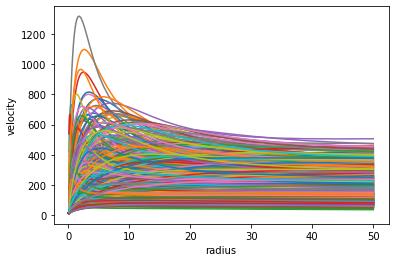

In [41]:
for v in cm.vc: plt.plot(cm.rad, v)
plt.xlabel('radius')
plt.ylabel('velocity');

### The Autoencoder network

We can now build our `Autoncoder` class deriving from `nn.Module`. In this example, each rotation curve is a collection of 50 values (see the radial grid in `curveMod`) and we want to compress it down to a `code` of just 4 numbers. Notice that we start from the simplified case in which we assume to already know that the ideal latent representation has 4 parameters. 

The `encoder` network has 3 layers, going from the initial $n=50$ to $32$, then to $16$, and finally to $4$. The `decoder` is symmetric, going from $n=4$ to $16$, then to $32$, and finally to $50$.

In [27]:
class AutoEncoder(nn.Module):
    def __init__(self, ninp, **kwargs):
        super().__init__()
        self.encodeLayer1 = nn.Linear(in_features=ninp, out_features=32)
        self.encodeLayer2 = nn.Linear(in_features=32,   out_features=16)
        self.encodeOut    = nn.Linear(in_features=16,   out_features=4)
        self.decodeLayer1 = nn.Linear(in_features=4,    out_features=16)
        self.decodeLayer2 = nn.Linear(in_features=16,   out_features=32)
        self.decodeOut    = nn.Linear(in_features=32,   out_features=ninp)
        
    def encoder(self, x):       return self.encodeOut(F.relu(self.encodeLayer2(F.relu(self.encodeLayer1(x)))))
    def decoder(self, encoded): return self.decodeOut(F.relu(self.decodeLayer2(F.relu(self.decodeLayer1(encoded)))))
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [29]:
AutoEncoder(len(cm.rad))

AutoEncoder(
  (encodeLayer1): Linear(in_features=50, out_features=32, bias=True)
  (encodeLayer2): Linear(in_features=32, out_features=16, bias=True)
  (encodeOut): Linear(in_features=16, out_features=4, bias=True)
  (decodeLayer1): Linear(in_features=4, out_features=16, bias=True)
  (decodeLayer2): Linear(in_features=16, out_features=32, bias=True)
  (decodeOut): Linear(in_features=32, out_features=50, bias=True)
)

### Data normalization and training/validation split

We now shuffle, normalize, and split the rotation curve dataset into training and validation with a 20% validation split.

In [30]:
def datanorm(x):  return (x-x.mean())/x.std(), x.mean(), x.std()
def datascale(x, m, s): return x*s+m

idshuff = torch.randperm(nsamp)
xdata = tensor(cm.vc, dtype=torch.float)[idshuff,:]
xdata, xmean, xstd = datanorm(xdata)

fval = 0.20
xtrain = xdata[:int(nsamp*(1.0-fval))]
xvalid = xdata[int(nsamp*(1.0-fval)):]

### Training loop

We now initialize the training loop, defining a simple `MSE` loss function and a standard `Adam` optimizer, and we start training

In [37]:
ae = AutoEncoder(len(cm.rad))

# Adam and MSE Loss
loss_func = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(ae.parameters(), lr=0.01)

for epoch in range(1001):
    ymod = ae.forward(xtrain)
    loss = loss_func(xtrain, ymod)
    
    loss.backward()
    
    optimizer.step()
    
    optimizer.zero_grad()
    
    if epoch%50==0: print (epoch, "train L:%1.2e" % loss, "  valid L:%1.2e" % loss_func(xvalid, ae.forward(xvalid)))

0 train L:1.04e+00   valid L:9.36e-01
50 train L:2.77e-02   valid L:2.33e-02
100 train L:5.27e-03   valid L:5.16e-03
150 train L:3.13e-03   valid L:3.33e-03
200 train L:2.59e-03   valid L:2.80e-03
250 train L:2.26e-03   valid L:2.12e-03
300 train L:1.59e-03   valid L:1.63e-03
350 train L:1.04e-03   valid L:1.14e-03
400 train L:9.29e-04   valid L:9.83e-04
450 train L:7.87e-04   valid L:8.51e-04
500 train L:9.03e-04   valid L:1.10e-03
550 train L:6.68e-04   valid L:7.73e-04
600 train L:6.68e-04   valid L:7.54e-04
650 train L:7.83e-04   valid L:7.54e-04
700 train L:6.77e-04   valid L:7.19e-04
750 train L:1.35e-03   valid L:1.92e-03
800 train L:4.56e-04   valid L:5.63e-04
850 train L:4.23e-04   valid L:5.46e-04
900 train L:8.74e-04   valid L:1.07e-03
950 train L:3.84e-04   valid L:4.79e-04
1000 train L:4.45e-04   valid L:4.95e-04


After 1000 epochs of trainig we get down to a low and stable MSE on the validation set. We can now compare the actual rotation curves in the validation set with those decoded by the model, finding an impressively good match!

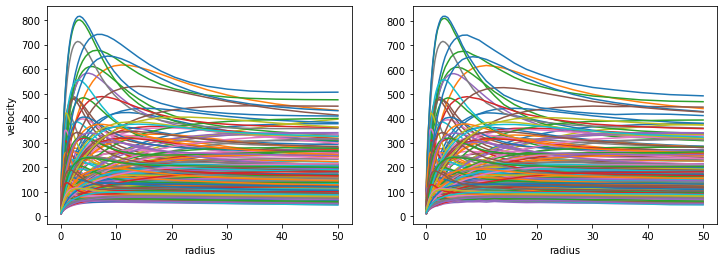

In [42]:
fig,ax = plt.subplots(figsize=(12,4), ncols=2)
for v in datascale(xvalid,xmean,xstd): ax[0].plot(cm.rad, v)
for v in datascale(ae.forward(xvalid),xmean,xstd): ax[1].plot(cm.rad, v.detach().numpy())
ax[0].set_xlabel('radius'); ax[1].set_xlabel('radius')
ax[0].set_ylabel('velocity');

### How does the `code` correlate with the original 4 physical parameters?

Finally we can explore a bit the properties of the 4 values encoded by the autoencoder and try to understand how do they relate to the original 4 physical parameters. Initially we generated each rotation curve starting from a 4-ple in `(ms, mh, rd, cc)`, where these numbers are generated from some well known scaling relations. We plot the distribution of the initial 4 parameters here:

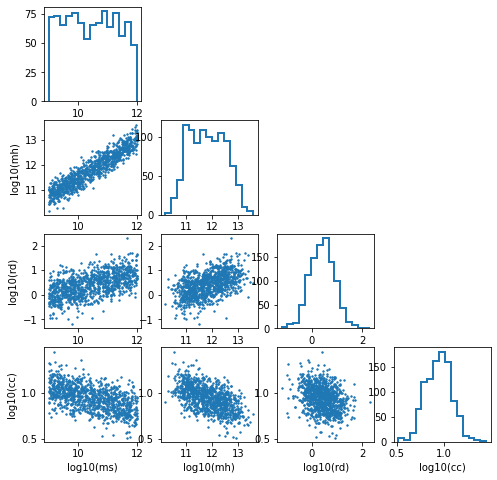

In [91]:
fig,ax = plt.subplots(figsize=(8,8), ncols=4, nrows=4)

pp = [ms, mh, rd, cc]

for i in range(4):
    for j in range(4):
        if j<i:  ax[i,j].scatter(np.log10(pp[j]), np.log10(pp[i]), s=2)
        if j==i: ax[i,j].hist(np.log10(pp[i]), bins=15, lw=2, histtype='step');
        if j>i:  ax[i,j].set_axis_off()
ax[3,0].set_xlabel('log10(ms)'); 
ax[3,1].set_xlabel('log10(mh)'); ax[1,0].set_ylabel('log10(mh)');
ax[3,2].set_xlabel('log10(rd)'); ax[2,0].set_ylabel('log10(rd)');
ax[3,3].set_xlabel('log10(cc)'); ax[3,0].set_ylabel('log10(cc)');

Now we can ask ourselves if similar correlations are observed in the 4 parameters coded by the autoencoder. In principle these are some other 4 numbers that fully specify a single rotation curve model, but that do not necessarily have anything to do with the original `(ms, mh, rd, cc)`.

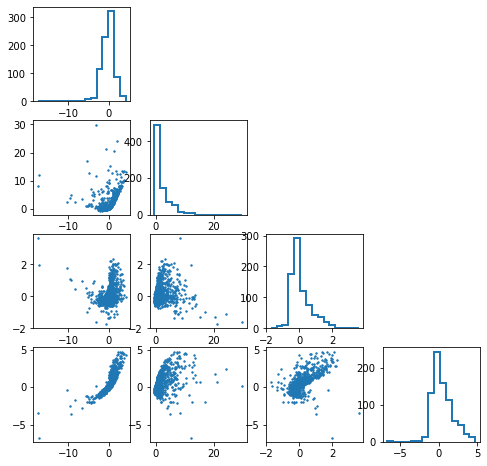

In [85]:
fig,ax = plt.subplots(figsize=(8,8), ncols=4, nrows=4)

pp_ae = ae.encoder(xtrain).detach()

for i in range(4):
    for j in range(4):
        if j<i:  ax[i,j].scatter(pp_ae[:,j], pp_ae[:,i], s=2)
        if j==i: ax[i,j].hist(pp_ae[:,i].detach().numpy(), bins=15, lw=2, histtype='step');
        if j>i:  ax[i,j].set_axis_off()

We can see that the coded parameters are indeed strongly correlated among themselves, however it is difficult to draw parallelisms with the behaviour we see in the original 4 parameters. An important difference to notice in these plots is that here we do not use a logarithmic scale for the 4 coded parameters, since they also take negative values unlike `(ms, mh, rd, cc)`.

Let's now have a look at how the 4 coded parameters are correlated with the original ones. This is interesting since while the 4-dimensional latent space found by the autoencoder is not necessarily the original space of `(ms, mh, rd, cc)`, the 4 new parameters might be well correlated with the 4 original physical quantites.

In [92]:
#| code-fold: true
mdshuff, mhshuff = [cm.Md[i] for i in idshuff], [cm.Mh[i] for i in idshuff]
rdshuff, ccshuff = [cm.Rd[i] for i in idshuff], [cm.cc[i] for i in idshuff]

ith = int(nsamp*(1.0-fval))
mdtrain, mhtrain = mdshuff[:ith], mhshuff[:ith]
rdtrain, cctrain = rdshuff[:ith], ccshuff[:ith]
mdvalid, mhvalid = mdshuff[ith:], mhshuff[ith:]
rdvalid, ccvalid = rdshuff[ith:], ccshuff[ith:]

partrain = (np.vstack([mdtrain, mhtrain, rdtrain, cctrain]).T)
parvalid = (np.vstack([mdvalid, mhvalid, rdvalid, ccvalid]).T)

Plotting the mutual correalations in the training set we do see that the 4 coded parameters are not at all randomly related to the original physical quantities.

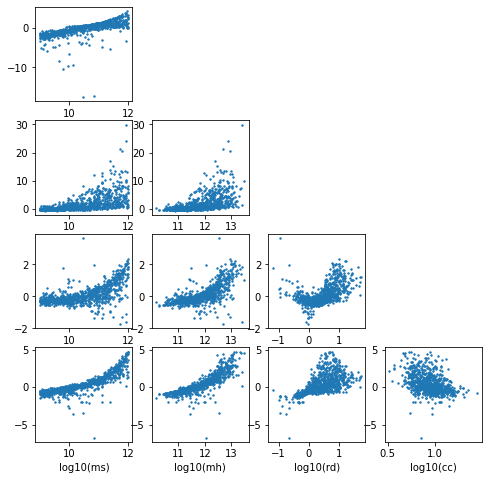

In [98]:
fig,ax = plt.subplots(figsize=(8,8), ncols=4, nrows=4)

pp_ae = ae.encoder(xtrain).detach()

for i in range(4):
    for j in range(4):
        if j<=i: ax[i,j].scatter(np.log10(partrain[:,j]), pp_ae[:,i], s=2)
        if j>i:  ax[i,j].set_axis_off()
ax[3,0].set_xlabel('log10(ms)'); 
ax[3,1].set_xlabel('log10(mh)'); 
ax[3,2].set_xlabel('log10(rd)'); 
ax[3,3].set_xlabel('log10(cc)'); 

### Generating new data with the autoencoder

To finish, let's have a look at how we can use the autoencoder to generate new fake data that resembles our original dataset. We do so by random sampling from the distribution of coded values that we obtained during training. In this way we generate a new plausible `code` which we then decode to construct a new rotation curve.

We start by generating new code from the distribution obtained during training - to do this we use `numpy.random.choice`

In [124]:
size=500

new_pp_ae = []
for i in range(4): new_pp_ae.append(tensor(np.random.choice(pp_ae[:,i].numpy(), size)))
new_code = torch.stack(new_pp_ae).T

Let's plot the original and new distributions of coded parameters:

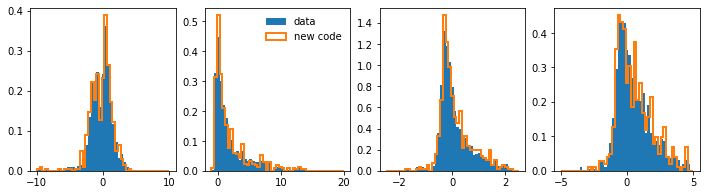

In [125]:
fig,ax = plt.subplots(figsize=(12,3), ncols=4)

bins=[np.linspace(-10,10,50), np.linspace(-1,20,50), np.linspace(-2.5,2.5,50), np.linspace(-5,5,50)]
for i in range(4):
    ax[i].hist(pp_ae[:,i].numpy(), bins=bins[i], density=True, label='data');
    ax[i].hist(new_code[:,i].numpy(), bins=bins[i], histtype='step', lw=2, density=True, label='new code');
    if i==1: ax[i].legend(loc='upper right', frameon=False)

Since they look very much alike we can now decode the new code that we just generated and we are ready to plot the new rotation curves

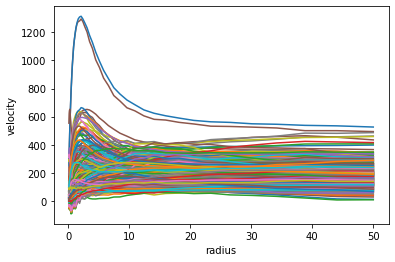

In [131]:
fig,ax = plt.subplots(figsize=(6,4))
for v in datascale(ae.decoder(new_code),xmean,xstd): ax.plot(cm.rad, v.detach().numpy())
ax.set_xlabel('radius')
ax.set_ylabel('velocity');

With this method we have effectively generated new rotation curves that are realistic and are not part of the training dataset. This illustrates the power of autoencoders, however to do this even better we can adapt our autoencoder to learn the underlying distribution in the code space - this is what Variatioal Autoencoders (VAEs) are for!